In [450]:
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Game type identifier

001 = Preseason
002 = Regular Season
003 = All-Star Game (Also includes Rising Stars games)
004 = Playoffs
005 = Play-In Tournament (introduced in 2020)
006 = NBA Cup Final (introduced in 2023)

In [592]:

nba_teams = teams.get_teams()
reg_playoff_games = ['002', '004', '005', '006']
gamefinder = leaguegamefinder.LeagueGameFinder(date_from_nullable='09/09/2020')
all_games = gamefinder.get_data_frames()[0]

all_games['GAME_DATE'] = pd.to_datetime(all_games['GAME_DATE'])

all_games = all_games['2020-09-09' <= all_games['GAME_DATE']]
all_games = all_games[all_games['GAME_ID'].astype(str).str.startswith(('002', '004', '005', '006'))]

all_games = all_games.dropna(subset=['WL'])

all_games.to_csv('all_games.csv')


Concatanate the same game pairs

In [593]:
teams = all_games["TEAM_NAME"].unique().tolist()
games_sorted = all_games.sort_values(by='GAME_DATE').drop([
        'SEASON_ID', 'TEAM_ID'], axis=1)
exclude_cols = ['TEAM_NAME', 'GAME_DATE', 'WL', 'GAME_ID']
cols_to_roll = [col for col in games_sorted.columns if col not in exclude_cols]
team_ma_A_list = []
for team in teams:
    sorted_team_vals = games_sorted[games_sorted["TEAM_NAME"] == team].sort_values(by='GAME_DATE')
    re_add_cols = sorted_team_vals[exclude_cols]
    team_ma_A_list.append(sorted_team_vals[cols_to_roll].rolling(5, min_periods=1).mean(numeric_only=True).join(re_add_cols))
df = pd.concat(team_ma_A_list)

In [599]:
# Delete observation for missing pair
df = df[df['GAME_ID'] !='0022000044']

In [610]:
home_cols = [col for col in df.columns if "_HOME" in col]
away_cols = [col.replace("_HOME_MA", "_AWAY_MA") for col in home_cols]
concat_arr = []
for name, groups in df.sort_values(by='GAME_ID').groupby(by=['GAME_ID']):
    g = groups.iloc[0].to_frame().transpose().merge(groups.iloc[1].to_frame().transpose(), on="GAME_ID", suffixes=("_HOME", "_AWAY"))
    concat_arr.append(g)
all_games_df = pd.concat(concat_arr)

In [611]:
all_games_df = all_games_df.set_index('GAME_ID')

In [614]:
all_games_df

,MIN_HOME,PTS_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,...,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PLUS_MINUS_AWAY,TEAM_NAME_AWAY,GAME_DATE_AWAY,WL_AWAY
GAME_ID,,,,,,,,,,,,,,,,,,,,,
0022000016,240.0,104.0,37.6,85.2,0.4424,11.8,36.2,0.322,17.0,25.4,...,43.8,20.8,6.4,4.4,16.8,17.4,-11.6,Oklahoma City Thunder,2021-03-21 00:00:00,W
0022000045,241.0,115.0,43.0,92.0,0.467,16.0,46.0,0.348,13.0,15.0,...,41.0,20.0,6.0,5.0,14.0,14.0,-8.0,Los Angeles Lakers,2020-12-28 00:00:00,L
0022000046,240.0,95.0,34.0,79.0,0.43,14.0,25.0,0.56,13.0,21.0,...,43.0,22.0,13.0,10.0,13.0,17.0,-9.0,Cleveland Cavaliers,2020-12-29 00:00:00,L
0022000047,241.0,116.0,38.0,76.0,0.5,14.0,33.0,0.424,26.0,36.0,...,45.0,21.0,8.0,6.0,15.0,26.0,-10.0,Detroit Pistons,2020-12-29 00:00:00,L
0022000048,239.0,116.0,40.0,80.0,0.5,9.0,22.0,0.409,27.0,37.0,...,36.0,27.0,9.0,5.0,14.0,25.0,-5.0,Indiana Pacers,2020-12-29 00:00:00,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0052300131,240.6,114.8,41.0,91.2,0.453,16.2,41.4,0.3956,16.6,20.4,...,45.0,28.4,6.4,7.8,14.4,16.2,0.0,Golden State Warriors,2024-04-16 00:00:00,L
0052300201,244.8,119.4,47.4,96.4,0.4908,12.0,34.2,0.3544,12.6,16.8,...,44.6,27.4,8.2,4.0,13.2,15.6,7.6,Miami Heat,2024-04-19 00:00:00,W
0052300211,239.8,113.6,43.8,88.0,0.4988,14.6,32.8,0.4298,11.4,15.2,...,41.4,26.0,9.8,3.2,11.6,17.8,8.6,Sacramento Kings,2024-04-19 00:00:00,L


In [615]:
# DROP irrelevant and non_feature columns
games_ma = all_games_df.drop(['WL_AWAY', 'MIN_HOME', 'MIN_AWAY'
    , 'PLUS_MINUS_HOME', 'PLUS_MINUS_AWAY', 'REB_HOME', 'REB_AWAY'], axis=1)
# games_ma = games_ma.rolling(5).mean()

# DROP features that are correlated
games_ma = games_ma.drop([
    'FTM_HOME', 'FTM_AWAY', 'FTA_AWAY', 'FTA_HOME', 'FGM_HOME', 'FGM_AWAY', 'FGA_HOME', 'FGA_AWAY', 'FG3M_HOME', 'FG3M_AWAY'], axis=1)

games_ma.loc[games_ma.isnull().any(axis=1), 'FT_PCT_AWAY'] = 0.779 # fill the missing free throw pct value with historical average

In [616]:
games_ma

,PTS_HOME,FG_PCT_HOME,FG3A_HOME,FG3_PCT_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,AST_HOME,STL_HOME,BLK_HOME,...,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,TEAM_NAME_AWAY,GAME_DATE_AWAY
GAME_ID,,,,,,,,,,,,,,,,,,,,,
0022000016,104.0,0.4424,36.2,0.322,0.705,8.6,31.0,22.4,7.0,4.4,...,0.7628,11.2,32.6,20.8,6.4,4.4,16.8,17.4,Oklahoma City Thunder,2021-03-21 00:00:00
0022000045,115.0,0.467,46.0,0.348,0.867,7.0,38.0,27.0,9.0,6.0,...,0.833,6.0,35.0,20.0,6.0,5.0,14.0,14.0,Los Angeles Lakers,2020-12-28 00:00:00
0022000046,95.0,0.43,25.0,0.56,0.619,14.0,41.0,23.0,9.0,6.0,...,0.682,14.0,29.0,22.0,13.0,10.0,13.0,17.0,Cleveland Cavaliers,2020-12-29 00:00:00
0022000047,116.0,0.5,33.0,0.424,0.722,4.0,36.0,21.0,8.0,8.0,...,0.793,16.0,29.0,21.0,8.0,6.0,15.0,26.0,Detroit Pistons,2020-12-29 00:00:00
0022000048,116.0,0.5,22.0,0.409,0.73,12.0,31.0,21.0,10.0,3.0,...,0.813,4.0,32.0,27.0,9.0,5.0,14.0,25.0,Indiana Pacers,2020-12-29 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0052300131,114.8,0.453,41.4,0.3956,0.8316,12.6,32.0,26.4,9.6,3.2,...,0.7676,9.0,36.0,28.4,6.4,7.8,14.4,16.2,Golden State Warriors,2024-04-16 00:00:00
0052300201,119.4,0.4908,34.2,0.3544,0.765,12.0,33.4,27.0,11.2,5.6,...,0.8664,11.6,33.0,27.4,8.2,4.0,13.2,15.6,Miami Heat,2024-04-19 00:00:00
0052300211,113.6,0.4988,32.8,0.4298,0.7492,8.2,34.2,28.8,7.8,3.6,...,0.8218,11.2,30.2,26.0,9.8,3.2,11.6,17.8,Sacramento Kings,2024-04-19 00:00:00


In [468]:
games_ma['PTS_AWAY'] = pd.to_numeric(games_ma['PTS_AWAY'])
games_ma['PTS_HOME'] = pd.to_numeric(games_ma['PTS_HOME'])

games_ma['FG3A_AWAY'] = pd.to_numeric(games_ma['FG3A_AWAY'])
games_ma['FG3A_HOME'] = pd.to_numeric(games_ma['FG3A_HOME'])

games_ma['AST_HOME'] = pd.to_numeric(games_ma['AST_HOME'])
games_ma['AST_AWAY'] = pd.to_numeric(games_ma['AST_AWAY'])

games_ma['DREB_HOME'] = pd.to_numeric(games_ma['DREB_HOME'])
games_ma['DREB_AWAY'] = pd.to_numeric(games_ma['DREB_AWAY'])

games_ma['BLK_HOME'] = pd.to_numeric(games_ma['BLK_HOME'])
games_ma['BLK_AWAY'] = pd.to_numeric(games_ma['BLK_AWAY'])

games_ma['OREB_AWAY'] = pd.to_numeric(games_ma['OREB_AWAY'])
games_ma['OREB_HOME'] = pd.to_numeric(games_ma['OREB_HOME'])

games_ma['TOV_AWAY'] = pd.to_numeric(games_ma['TOV_AWAY'])
games_ma['TOV_HOME'] = pd.to_numeric(games_ma['TOV_HOME'])

games_ma['PF_AWAY'] = pd.to_numeric(games_ma['PF_AWAY'])
games_ma['PF_HOME'] = pd.to_numeric(games_ma['PF_HOME'])

games_ma['STL_AWAY'] = pd.to_numeric(games_ma['STL_AWAY'])
games_ma['STL_HOME'] = pd.to_numeric(games_ma['STL_HOME'])

In [617]:
home_cols = [col for col in games_ma.columns if col.endswith('_HOME') and col not in exclude_cols]
away_cols = [col.replace('_HOME', '_AWAY') for col in home_cols if col.replace('_HOME', '_AWAY') in games_ma.columns]

diff_cols = []
for home, away in zip(home_cols, away_cols):
    print(home, away)
    diff_col = home.replace('_HOME', '_MA_DIFF')
    diff_cols.append(diff_col)
    games_ma[diff_col] = (games_ma[home] - games_ma[away]).astype(float)

PTS_HOME PTS_AWAY
FG_PCT_HOME FG_PCT_AWAY
FG3A_HOME FG3A_AWAY
FG3_PCT_HOME FG3_PCT_AWAY
FT_PCT_HOME FT_PCT_AWAY
OREB_HOME OREB_AWAY
DREB_HOME DREB_AWAY
AST_HOME AST_AWAY
STL_HOME STL_AWAY
BLK_HOME BLK_AWAY
TOV_HOME TOV_AWAY
PF_HOME PF_AWAY
TEAM_NAME_HOME TEAM_NAME_AWAY


TypeError: unsupported operand type(s) for -: 'str' and 'str'

Checking multicollinearity

In [462]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = all_games[diff_cols].columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(all_games.values, i)
                   for i in range(len(all_games.columns))]

print(vif_data)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

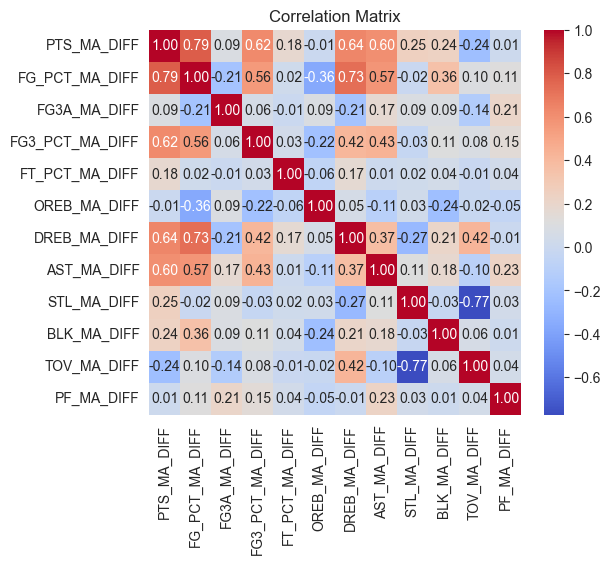

In [506]:
corr_matrix = all_games[diff_cols].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Removing columns that are correlated

In [ ]:
diff_cols

In [507]:
feature_cols = [col for col in all_games.columns if "_DIFF" in col]  # Selecting only _DIFF columns

scaler = StandardScaler()
all_games[feature_cols] = scaler.fit_transform(all_games[feature_cols])

In [511]:
all_games[feature_cols]

,PTS_MA_DIFF,FG_PCT_MA_DIFF,FG3A_MA_DIFF,FG3_PCT_MA_DIFF,FT_PCT_MA_DIFF,OREB_MA_DIFF,DREB_MA_DIFF,AST_MA_DIFF,STL_MA_DIFF,BLK_MA_DIFF,TOV_MA_DIFF,PF_MA_DIFF
24310,0.066784,0.366364,-2.264092,-0.339933,-0.541191,0.900517,1.403108,-0.832866,-0.974706,1.122513,1.392683,-0.158716
24292,-1.198768,-0.284717,-1.311069,0.231930,-1.361337,-0.933562,-0.094988,-1.996536,-0.238432,0.243118,1.196516,0.654726
24217,0.533039,-0.792560,0.489085,0.711287,-0.225751,0.900517,-1.048322,0.767180,0.497842,-0.929409,-1.745991,0.044644
23986,0.133392,-0.232631,-0.358046,0.173062,-0.450064,0.350293,-0.912131,0.330804,1.234116,0.243118,-1.353657,-0.972159
23925,-1.531808,-0.271695,-0.569829,-0.667914,-1.767905,-1.667193,-1.320703,0.767180,0.252417,0.829382,-0.176654,-0.362077
...,...,...,...,...,...,...,...,...,...,...,...,...
925,1.398943,0.249169,1.336217,1.367248,1.218266,0.350293,1.266917,-0.396490,-0.729282,-0.636278,-0.176654,-0.362077
874,0.266607,0.079888,1.018542,0.501043,-0.316878,-0.199930,0.041203,0.476262,-0.729282,0.243118,0.608015,-0.362077
620,-0.665904,-0.532128,0.489085,0.299209,-1.809964,-0.933562,-1.456893,0.912638,2.215815,0.243118,-0.961322,1.468168
550,3.397183,3.022774,1.124434,2.536205,-0.106584,-0.199930,2.765013,2.512684,-0.238432,-0.050014,0.608015,0.248005


In [508]:
X_train = all_games.sample(frac=0.7, replace=False, random_state=2)[diff_cols]
Y_train = [1 if wl == 'W' else 0 for wl in all_games[all_games.index.isin(X_train.index)].WL_HOME]

X_test = all_games.drop(index=X_train.index)[diff_cols]
Y_test = [1 if wl == 'W' else 0 for wl in all_games.drop(index=X_train.index).WL_HOME]
clf = LogisticRegression(random_state=0).fit(X_train.to_numpy(), Y_train)

In [514]:
X_train.join(Y_train)

0.5499451152579583

In [509]:
pd.concat(
    [pd.DataFrame(X_train.columns), pd.DataFrame(np.transpose(clf.coef_)), pd.DataFrame((np.transpose(clf.coef_) / 4) * 100)],
    axis=1)

,0,0,0
0,PTS_MA_DIFF,-0.002426,-0.060645
1,FG_PCT_MA_DIFF,0.034742,0.868562
2,FG3A_MA_DIFF,-0.034222,-0.855541
3,FG3_PCT_MA_DIFF,-0.042579,-1.064467
4,FT_PCT_MA_DIFF,0.081491,2.037275
5,OREB_MA_DIFF,0.030781,0.769527
6,DREB_MA_DIFF,-0.059311,-1.482763
7,AST_MA_DIFF,-0.015308,-0.382693
8,STL_MA_DIFF,0.081964,2.049094
9,BLK_MA_DIFF,-0.017656,-0.441392


In [510]:
clf.score(X_test, Y_test, sample_weight=None)

/Users/cancokisler/.virtualenvs/NBA_Analytics/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


0.5362239297475302

In [516]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train.to_numpy(), Y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(Y_test, y_pred)
report = classification_report(Y_test, y_pred)

accuracy, report

/Users/cancokisler/.virtualenvs/NBA_Analytics/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


(0.4994511525795829,
 '              precision    recall  f1-score   support\n\n           0       0.41      0.25      0.31       820\n           1       0.53      0.70      0.61      1002\n\n    accuracy                           0.50      1822\n   macro avg       0.47      0.48      0.46      1822\nweighted avg       0.48      0.50      0.47      1822\n')